#Классификация изображений: Cats vs Dogs

Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs.
[Датасет](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from keras.applications import ResNet50

print(tf.__version__)
print(tf.executing_eagerly())

2.15.0
True


##Функции загрузки данных

In [2]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/Kaggle/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!unzip dogs-vs-cats-redux-kernels-edition.zip
!unzip train.zip
!unzip test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/5499.jpg           
  inflating: test/55.jpg             
  inflating: test/550.jpg            
  inflating: test/5500.jpg           
  inflating: test/5501.jpg           
  inflating: test/5502.jpg           
  inflating: test/5503.jpg           
  inflating: test/5504.jpg           
  inflating: test/5505.jpg           
  inflating: test/5506.jpg           
  inflating: test/5507.jpg           
  inflating: test/5508.jpg           
  inflating: test/5509.jpg           
  inflating: test/551.jpg            
  inflating: test/5510.jpg           
  inflating: test/5511.jpg           
  inflating: test/5512.jpg           
  inflating: test/5513.jpg           
  inflating: test/5514.jpg           
  inflating: test/5515.jpg           
  inflating: test/5516.jpg           
  inflating: test/5517.jpg           
  inflating: test/5518.jpg           
  inflating: test/5519.jpg           
  inflating: test/552.jpg            

In [5]:
test_files = glob('test/*.jpg')
for file_path in test_files[:5]:
    print(file_path)

if not test_files:
    print("Список файлов пуст.")
else:
    for file_path in test_files[:5]:
        print(file_path)

test/6052.jpg
test/1123.jpg
test/4690.jpg
test/3950.jpg
test/8724.jpg
test/6052.jpg
test/1123.jpg
test/4690.jpg
test/3950.jpg
test/8724.jpg


In [7]:
from keras.preprocessing import image

In [8]:
batch_size = 32  # Размер пакета изображений для загрузки

In [10]:
train_files = glob('train/*.jpg')
for file_path in train_files[:5]:
    print(file_path)

if not train_files:
    print("Список файлов пуст.")
else:
    for file_path in train_files[:5]:
        print(file_path)

train/dog.8594.jpg
train/cat.7398.jpg
train/dog.1381.jpg
train/dog.1489.jpg
train/cat.10017.jpg
train/dog.8594.jpg
train/cat.7398.jpg
train/dog.1381.jpg
train/dog.1489.jpg
train/cat.10017.jpg


In [13]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    img = preprocess_input(img)  # Предобработка для ResNet50
    return img

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [15]:
def image_generator(file_paths, batch_size, img_size):
    i = 0
    while True:
        batch_paths = file_paths[i:i+batch_size]
        batch_images = []
        for file_path in batch_paths:
            img = cv2.imread(file_path)  # Загрузка изображения с помощью OpenCV
            img = cv2.resize(img, img_size)  # Изменение размера изображения
            img = preprocess_input(img)  # Предобработка для ResNet50
            batch_images.append(img)
        yield np.array(batch_images),
        i += batch_size
        if i >= len(file_paths):
            i = 0

In [16]:
# Генерация изображений
test_image_generator = image_generator(test_files, batch_size, IMG_SIZE)

In [17]:
for _ in range(5):  # Примерно пять пакетов изображений
    batch_images = next(test_image_generator)

##Визуализируем примеры для обучения

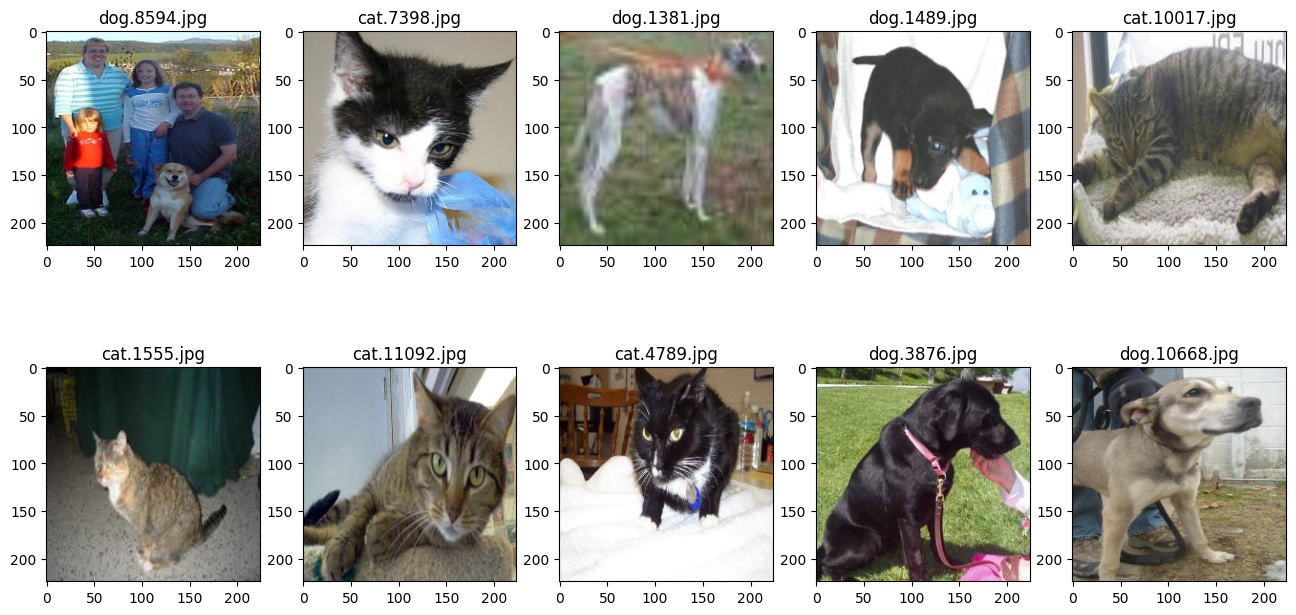

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

##Загружаем предобученную модель

In [19]:
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

94765736/94765736 [==============================] - 1s 0us/step


In [20]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

##Добавляем полносвязный слой

In [21]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output

# Добавляем операцию глобального усреднения
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Добавляем полносвязный слой с сигмоидной активацией
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Добавляем слой отсева для предотвращения переобучения
x = tf.keras.layers.Dense(1, activation='sigmoid')(x) #Выходной слой  с активацией сигмоид

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

##Выводим архитектуру модели

In [22]:
model.summary()

Model: "dogs_vs_cats"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                   

##Компилируем модель и запускаем обучение

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [24]:
val_samples = 200  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=10,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/20
10/10 [==============================] - 186s 17s/step - loss: 0.5101 - accuracy: 0.8250 - val_loss: 0.3430 - val_accuracy: 0.9750
Epoch 2/20
10/10 [==============================] - 171s 18s/step - loss: 0.2690 - accuracy: 0.9531 - val_loss: 0.1847 - val_accuracy: 0.9750
Epoch 3/20
10/10 [==============================] - 170s 18s/step - loss: 0.1839 - accuracy: 0.9563 - val_loss: 0.1132 - val_accuracy: 0.9800
Epoch 4/20
10/10 [==============================] - 165s 18s/step - loss: 0.1223 - accuracy: 0.9688 - val_loss: 0.0833 - val_accuracy: 0.9800
Epoch 5/20
10/10 [==============================] - 168s 18s/step - loss: 0.0820 - accuracy: 0.9844 - val_loss: 0.0668 - val_accuracy: 0.9850
Epoch 6/20
10/10 [==============================] - 167s 17s/step - loss: 0.0907 - accuracy: 0.9781 - val_loss: 0.0605 - val_accuracy: 0.9750
Epoch 7/20
10/10 [==============================] - 165s 18s/step - loss: 0.1125 - accuracy: 0.9531 - val_loss: 0.0719 - val_accuracy: 0.9700
Epoch 

In [25]:
model.save('cats-dogs-resnet50.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Предсказания на проверочной выборке

In [26]:
# Перезапуск генератора
test_image_generator = image_generator(test_files, batch_size, IMG_SIZE)

In [27]:
# Получение числа изображений в тестовом наборе
num_test_images = len(test_files)

In [28]:
# Округляем вверх, чтобы учесть оставшиеся изображения
steps_per_epoch = (num_test_images + batch_size - 1) // batch_size

In [29]:
test_pred = model.predict(
    test_image_generator, steps=steps_per_epoch)

391/391 [==============================] - 3182s 8s/step


<ipython-input-31-fb6ddecd4396>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  subplot.set_title('%.2f %s' % (score, os.path.basename(path)))


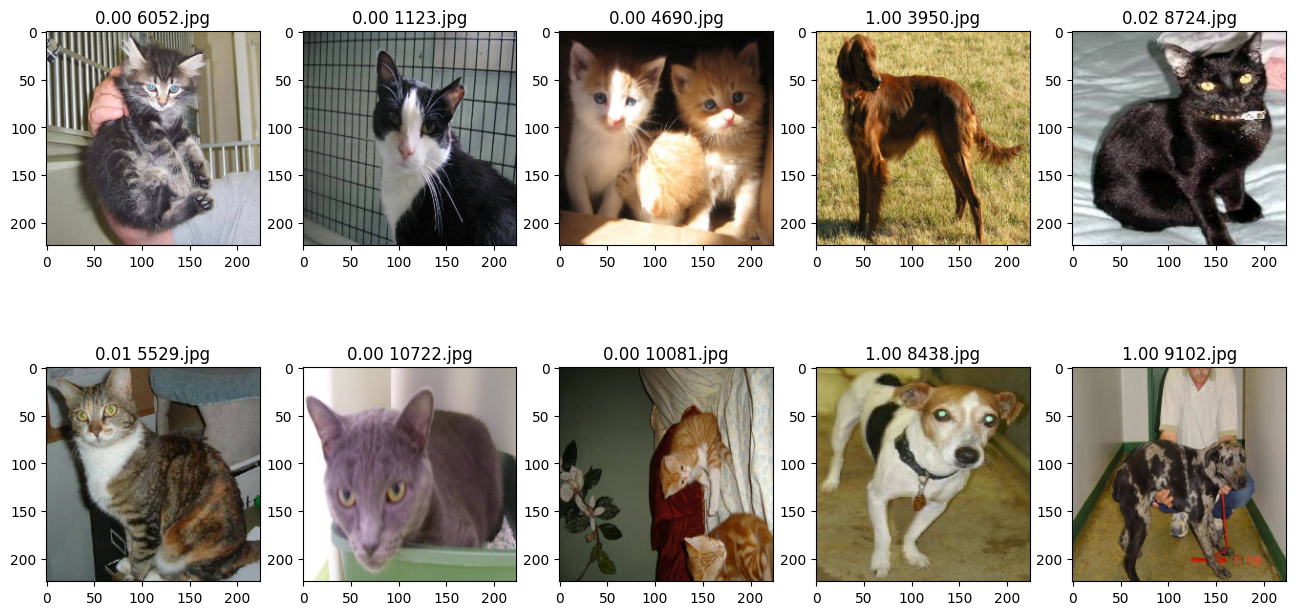

In [31]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

##Данные для отправки

In [32]:
import re

with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        # Используем регулярное выражение для извлечения ID из названия файла и пишем его вместе с соответствующим ему score в файл
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

<ipython-input-32-fde32d32987d>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))


Loss: 0.10376